In [54]:
# using tensorflow_gpuenv

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import requests, zipfile, io
import scipy
import time

hello=tf.constant('Hello,TensorFlow!')

sess=tf.Session()

print(sess.run(hello))


b'Hello,TensorFlow!'


## Getting the vocabulary

We determine our vocabulary by looking at the Google "English 1 Million" unigram data. Since this comes from the same source as the ngram data we will be studying, this provides consistnecy. Additionally, since this data is drawn from sources spanning the time period we're studing, it can be expected to be more representative of english over this broader time period, while other sources may reflect a more modern english.

### Tokenizing

In order to simplify the text we're looking at, all text is converted to lowercase and all "words" composed entirely of non-alphabetic symbols are replaced with a "#NUM" tag. If a non-alphabetic symbol appears partway through a word (e.g. an apostrophe or hyphen), only the first part of the word will be recorded.

In [57]:
all_words = {}

def clean_word(string):
    wordlist = re.findall(r"[a-z]+", string.lower())
    word = ""
    if len(wordlist) == 0:
        word = "#NUM"
    else:
        word = wordlist[0]
    return word
    

def get_word_counts(data, all_words):
    for index, row in data.iterrows():
        currentword = str(row["word"])
        word = clean_word(currentword)
        if word in all_words:
            all_words[word] += row["total"]
        else:
            all_words[word] = row["total"]

In [58]:
for i in range(10):
    filename = "googlebooks-eng-1M-1gram-20090715-" + str(i) + ".csv"
    data = pd.read_csv(filename, 
                       sep = '\t', 
                       header = None, 
                       names = ["word","year","total","pages","books"],
                       quotechar=None, 
                       quoting=3,
                       encoding = "ISO-8859-1")
    print(data.head())
    get_word_counts(data, all_words)

  word  year  total  pages  books
0    #  1574      1      1      1
1    #  1584      6      6      1
2    #  1614      1      1      1
3    #  1631    115    100      1
4    #  1632      3      3      1


KeyboardInterrupt: 

In [ ]:
keys = random.sample(list(all_words), 1000)
print(keys)

In [ ]:
len(all_words)

In [ ]:
counts = []
for word in keys:
    count = all_words[word]
    counts.append(count)
    if(count>1e7):
        print(word)
        print(count)
plt.hist(counts)

In [ ]:
top_words = {}
word_to_index = {}
index_to_word = {}
cutoff = 1e5
top_word_count = 0
extra_word_count = 0
i = 0
for word, count in all_words.items():
    if(count>cutoff):
        top_words[word] = count
        top_word_count += count
        word_to_index[word] = i
        index_to_word[i] = word
        i += 1
    else:
        extra_word_count += count
        
print(str(len(top_words)) + " words")
print("appearing " + str(top_word_count) + " times")
print("others appear " + str(extra_word_count) + " times")

In [ ]:
print(top_word_count/(extra_word_count + top_word_count))

In [ ]:
pd.DataFrame.from_dict(top_words, orient='index').to_csv("vocabCounts.csv")
pd.DataFrame.from_dict(index_to_word, orient='index').to_csv("vocabIndexed.csv")

In [59]:
# before: 
def load_vocab(top_word_dict, word_to_index_dict, index_to_word_dict):
    top_word_df = pd.read_csv("vocabCounts.csv", names=["word","count"], header=0)
    total_count = 0
    for index, row in top_word_df.iterrows():
        top_word_dict[row["word"]] = row["count"]
        total_count += row["count"]
        word_to_index_dict[row["word"]] = index
        index_to_word_dict[index]=row["word"]
    return total_count
    
    
def subsample_prob(top_word_dict, index_to_word_dict, total_word_count):
    threshold = 1e-5
    probs = np.ones(len(index_to_word_dict))
    for index in range(len(index_to_word_dict)):
        word = index_to_word_dict[index]
        freq = top_word_dict[word] * 1.0/total_word_count
        probs[index] = 1 - np.sqrt(threshold/freq)
    return probs
    
    

In [60]:
top_words = {}
word_to_index = {}
index_to_word = {}

total_count = load_vocab(top_words, word_to_index, index_to_word)
print(total_count)
probs = subsample_prob(top_words, index_to_word, total_count)

103341534423


In [61]:
maxyear = 2008
minyear = 1800

decades = range(minyear - minyear%10, maxyear, 10)

According to Mikolov, the best results from skipgram came from training with a loss function of negative sampling with k=15. This means using "tf.nn.sampled_softmax_loss" with num_sampled = 15, num_classes = vocab size, and num_true=1.
source: https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss

From hw4:

embed_shape = [self.V, self.H]

self.W_in_ = tf.get_variable("W_in", embed_shape, initializer=tf.initializers.random_uniform(minval=-1.0,maxval=1.0))

x_in_ = tf.nn.embedding_lookup(self.W_in_, self.input_w_)

In [68]:
vocab_size = len(top_words) + 1
embed_dim = 300
neg_samples = 15
learning_rate_ = .001

In [69]:
W_e_ = {}
W_nce_ = {}
b_nce_ = {}

print("Data from " + str(minyear) + " to " + str(maxyear))
for decade in decades:
    # initialize embeddings
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE): 
        W_e_[decade] = tf.get_variable("W_e_" + str(decade), 
                       [vocab_size, embed_dim], 
                       initializer = tf.initializers.random_uniform(minval=-1.0,
                                                                    maxval=1.0, 
                                                                    seed = 47))
        W_nce_[decade] = tf.get_variable("W_nce_" + str(decade), 
                       [vocab_size, embed_dim], 
                       initializer = tf.initializers.random_uniform(minval=-1.0,
                                                                    maxval=1.0, 
                                                                    seed = 47))
        b_nce_[decade] = tf.get_variable("b_nce_" + str(decade), 
                       [vocab_size])

Data from 1800 to 2008


follow the directions in https://www.tensorflow.org/tutorials/representation/word2vec to get skipgram model running

In [70]:
v_center_ = {}
v_context_0_= {}
v_context_1_ = {}
v_context_3_ = {}
v_context_4_ = {}
train_loss_ = {}
train_step_ = {}

batch_size = 32

center_word_ids_ = tf.placeholder(tf.int32, [batch_size])
context_word_id_0_ = tf.placeholder(tf.int32, [batch_size,1])
context_word_id_1_ = tf.placeholder(tf.int32, [batch_size,1])
context_word_id_3_ = tf.placeholder(tf.int32, [batch_size,1])
context_word_id_4_ = tf.placeholder(tf.int32, [batch_size,1])

for decade in decades:

    v_center_[decade] = tf.nn.embedding_lookup(W_e_[decade], center_word_ids_)
    
    
    train_loss_[decade] = tf.add(tf.add(tf.reduce_mean(tf.nn.sampled_softmax_loss(
        weights = W_2e_[decade],
        biases = tf.zeros([embed_dim]),
        labels = context_word_id_0_,
        inputs = v_center_[decade],
        num_sampled = neg_samples,
        num_classes = vocab_size,
        num_true=1)),
                                        tf.reduce_mean(tf.nn.sampled_softmax_loss(
        weights = W_2e_[decade],
        biases = tf.zeros([embed_dim]),
        labels = context_word_id_1_,
        inputs = v_center_[decade],
        num_sampled = neg_samples,
        num_classes = vocab_size,
        num_true=1))),
                                 tf.add(tf.reduce_mean(tf.nn.sampled_softmax_loss(
        weights = W_2e_[decade],
        biases = tf.zeros([embed_dim]),
        labels = context_word_id_3_,
        inputs = v_center_[decade],
        num_sampled = neg_samples,
        num_classes = vocab_size,
        num_true=1)),
                                        tf.reduce_mean(tf.nn.sampled_softmax_loss(
        weights = W_2e_[decade],
        biases = tf.zeros([embed_dim]),
        labels = context_word_id_4_,
        inputs = v_center_[decade],
        num_sampled = neg_samples,
        num_classes = vocab_size,
        num_true=1))))
                                        
    
    train_step_[decade] = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(train_loss_[decade])
init=tf.global_variables_initializer()

In [71]:
def ngram_to_decade_dict(fileurl, wordindices, decades):
    #response = requests.get(fileurl)
    #zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    #zip_file.extractall("temp")
    
    decade_dicts = {}
    for decade in decades:
        # initialize dictionary
        decade_dicts[decade] = {}
        
    data = 0
    start = time.time()
    while True:
        try:
            data = pd.read_csv(fileurl, 
                       sep = '\t', 
                       header = None, 
                       names = ["words","year","total","pages","books"],
                       quotechar=None, 
                       quoting=3,
                       encoding = "ISO-8859-1")
        except:
            print("trying downloading "+ fileurl + " again... ")
        else:
            break
    end = time.time()
    print(str(end-start) + " elapsed while downloading and reading to csv")
            
    start = time.time()
    
    for index, row in data.iterrows():
        year = row["year"]
        decade = year - year % 10
        
        if(decade in decade_dicts):
            # get and split words, convert them to indices 
            wordlist = str(row["words"]).lower().split(" ")
            indexlist = [vocab_size - 1,vocab_size -1,vocab_size -1,vocab_size -1,vocab_size -1]
            for i in range(len(wordlist)):
                currentword = wordlist[i]
                cleanword = clean_word(currentword)
                if(cleanword in wordindices):
                    indexlist[i] = wordindices[cleanword]
            indextuple = tuple(indexlist)

            year = row["year"]
            decade = year - year % 10

            count = row["total"]

            if(indextuple in decade_dicts[decade]):
                decade_dicts[decade][indextuple] += count
            else:
                decade_dicts[decade][indextuple] = count
    end = time.time()
    print(str(end-start) + " elapsed while converting to dict")
    return decade_dicts

In [72]:
sess.run(init)

run skipgram for each decade

In [73]:
max_iter = 10000


for filenum in range(0,800,100):
    url = "http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-" + str(filenum) +".csv.zip"
    print("downloaded " + url)
    decade_dicts = ngram_to_decade_dict(url, word_to_index, decades)
    for decade in decades:
        num_ngrams = len(decade_dicts[decade])
        if(num_ngrams >= batch_size):
            print("Training decade " + str(decade))
            max_decade_iter = min(max_iter, int(num_ngrams/(batch_size)))
            for iteration in range(max_decade_iter):
                traindata = random.choices(list(decade_dicts[decade].keys()), 
                                           weights = list(decade_dicts[decade].values()), 
                                           k=batch_size)

                feed_dict = {
                    context_word_id_0_ :  np.array([x[2] for x in traindata]).reshape((batch_size,1)),
                    context_word_id_1_ :  np.array([x[1] for x in traindata]).reshape((batch_size,1)),
                    center_word_ids_ : [x[0] for x in traindata],
                    context_word_id_3_ :  np.array([x[3] for x in traindata]).reshape((batch_size,1)),
                    context_word_id_4_ :  np.array([x[4] for x in traindata]).reshape((batch_size,1))
                }

                ops = [train_loss_[decade], train_step_[decade]]        

                cost1, _ = sess.run(ops, feed_dict)
                
                feed_dict = {
                    context_word_id_0_ :  np.array([x[0] for x in traindata]).reshape((batch_size,1)),
                    context_word_id_1_ :  np.array([x[1] for x in traindata]).reshape((batch_size,1)),
                    center_word_ids_ : [x[2] for x in traindata],
                    context_word_id_3_ :  np.array([x[3] for x in traindata]).reshape((batch_size,1)),
                    context_word_id_4_ :  np.array([x[4] for x in traindata]).reshape((batch_size,1))
                }

                ops = [train_loss_[decade], train_step_[decade]]        

                cost2, _ = sess.run(ops, feed_dict)
                
                feed_dict = {
                    context_word_id_0_ :  np.array([x[0] for x in traindata]).reshape((batch_size,1)),
                    context_word_id_1_ :  np.array([x[1] for x in traindata]).reshape((batch_size,1)),
                    center_word_ids_ : [x[4] for x in traindata],
                    context_word_id_3_ :  np.array([x[3] for x in traindata]).reshape((batch_size,1)),
                    context_word_id_4_ :  np.array([x[2] for x in traindata]).reshape((batch_size,1))
                }

                ops = [train_loss_[decade], train_step_[decade]]        

                cost3, _ = sess.run(ops, feed_dict)
                
                if(iteration % 1000 == 0):
                    print(str(cost1) + ", "+str(cost2) + ", " + str(cost3))        
    

downloaded http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-0.csv.zip
13.802543640136719 elapsed while downloading and reading to csv


KeyboardInterrupt: 

In [ ]:
# TODO:
# save vocab to csv - DONE
# check metrics of bias by decade: what metrics?
# align different decades while preserving cosine similarity
# save embeddiing matrices to files
# make pretty graphs
# try nn? cnn? rnn? to predict embedding from previous embeddings

In [20]:
last_decade = decades[-1]
most_recent_embed = sess.run(W_e_[last_decade])
aligned_embeddings = {}
embeddings = {}
aligned_matrix = np.zeros([len(decades), embed_dim, vocab_size])


# align past decades to current english using orthogonal procrustes
for i, decade in enumerate(decades):
    decade_embed =  sess.run(W_e_[decade])
    embeddings[decade] = decade_embed
    conversion = scipy.linalg.orthogonal_procrustes(decade_embed, most_recent_embed)
    print(str(decade) + " aligns with svd sum "+str(conversion[1]))
    aligned = np.dot(decade_embed, conversion[0])
    aligned_embeddings[decade] = aligned
    aligned_matrix[i] = aligned.T
    
# save to a file for future reference
# np.savetxt("saved_embeddings.csv", aligned_matrix)
#d.DataFrame.from_dict(aligned_embeddings, orient='index').to_csv("embeddings.csv")

1520 aligns with svd sum 983586.0
1530 aligns with svd sum 983586.0
1540 aligns with svd sum 983586.0
1550 aligns with svd sum 983586.0
1560 aligns with svd sum 983586.0
1570 aligns with svd sum 983580.25
1580 aligns with svd sum 983521.9
1590 aligns with svd sum 983580.8
1600 aligns with svd sum 983586.0
1610 aligns with svd sum 983581.9
1620 aligns with svd sum 983586.0
1630 aligns with svd sum 983520.4
1640 aligns with svd sum 983413.94
1650 aligns with svd sum 983537.25
1660 aligns with svd sum 983299.4
1670 aligns with svd sum 983368.5
1680 aligns with svd sum 983226.1
1690 aligns with svd sum 983403.25
1700 aligns with svd sum 982942.5
1710 aligns with svd sum 982381.9
1720 aligns with svd sum 981989.5
1730 aligns with svd sum 981200.75
1740 aligns with svd sum 979933.1
1750 aligns with svd sum 977680.56
1760 aligns with svd sum 977105.25
1770 aligns with svd sum 975168.6
1780 aligns with svd sum 971527.75
1790 aligns with svd sum 967626.2
1800 aligns with svd sum 944539.6
1810 a

In [21]:
def embedding_lookup(word,embeddingmx):
    wordindex = word_to_index[word]
    embedding = embeddingmx[wordindex]
    return embedding
    

In [44]:
# visualize on "he-she" projection vs time
def cos_sim(x,y):
    return np.dot(x,y)/np.sqrt(np.dot(x,x)*np.dot(y,y))
    
    

def bias_portion(word, bias_word_1, bias_word_2, decades, embedding_dict):
    bias_portions = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        bias1embed = embedding_lookup(bias_word_1,embedding_dict[decade])
        bias2embed = embedding_lookup(bias_word_2,embedding_dict[decade])
        biasdiff = bias1embed - bias2embed
        wordembed = embedding_lookup(word, embedding_dict[decade])
        cos = cos_sim(biasdiff, wordembed)
        bias_portions[i] = cos
    return bias_portions
        
def bias_portion_pair(word1, word2, bias_word_1, bias_word_2, decades, embedding_dict):
    bias_portions = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        bias1embed = embedding_lookup(bias_word_1,embedding_dict[decade])
        bias2embed = embedding_lookup(bias_word_2,embedding_dict[decade])
        biasdiff = bias1embed - bias2embed
        word1embed = embedding_lookup(word1, embedding_dict[decade])
        word2embed = embedding_lookup(word2, embedding_dict[decade])
        worddiff = word1embed - word2embed
        cos = cos_sim(word1embed,word2embed+biasdiff)
        bias_portions[i] = cos
    return bias_portions

def cos_sim_time(word1, word2, decades, embedding_dict):
    sims = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        word1embed = embedding_lookup(word1, embedding_dict[decade])
        word2embed = embedding_lookup(word2, embedding_dict[decade])
        cos = cos_sim(word1embed, word2embed)
        sims[i] = cos
    return sims
        

graph results

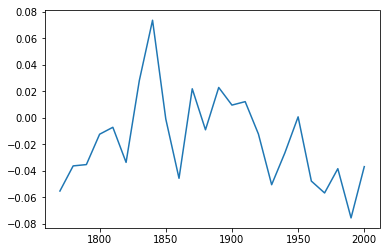

In [45]:
word1 = "weak"
word2 = "h"
bias_word_1 = "man"
bias_word_2 = "woman"


plt.plot(decades[25:],bias_portion(word1, bias_word_1, bias_word_2, decades[25:], embeddings))

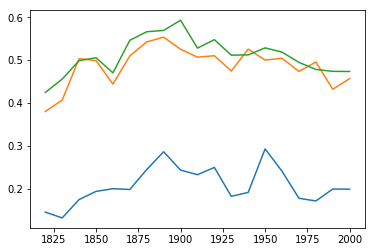

In [53]:
word1 = "strong"
word2 = "weak"
plt.plot(decades[30:],bias_portion_pair(word1, word2, bias_word_1, bias_word_2, decades[30:], embeddings))
word1 = "he"
word2 = "she"
plt.plot(decades[30:],bias_portion_pair(word1, word2, bias_word_1, bias_word_2, decades[30:], embeddings))
word1 = "the"
word2 = "an"
plt.plot(decades[30:],bias_portion_pair(word1, word2, bias_word_1, bias_word_2, decades[30:], embeddings))

In [29]:
def complete_analogy(a,b,c, embeddings):
    embeda = embedding_lookup(a, embeddings)
    embedb = embedding_lookup(b, embeddings)
    embedc = embedding_lookup(c, embeddings)
    target = embedc-embedb+embeda
    maxsim = 0
    maxword = ""
    for word, index in word_to_index.items():
        wordembed = embedding_lookup(word, embeddings)
        cos = cos_sim(wordembed, target)
        if(cos > maxsim):
            maxword = word
            maxsim = cos
    return maxword
        
print(complete_analogy("man","woman","king", embeddings[1910]))
print(complete_analogy("he","she","uncle", embeddings[1910]))
print(complete_analogy("he","she","brother", embeddings[1910]))
print(complete_analogy("he","she","boy", embeddings[1910]))
print(complete_analogy("he","she","man", embeddings[1910]))
        
        

man
uncle
brother
boy
man
